In [1]:
import joblib
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
gbr = joblib.load('fydyc/梯度提升20*8.pkl')

# 进行预测
X_new = np.array([[2, 3], [6, 7]])
y_pred = gbr.predict(X_new)

print("输入特征:")
print(X_new)
print("预测值:")
print(y_pred)

输入特征:
[[2 3]
 [6 7]]
预测值:
[0.51594867 0.51594867]


In [2]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from fydyc_dataset import FydycDataset
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import OrderedDict
class PolynomialRegression(nn.Module):
    def __init__(self, degree):
        super(PolynomialRegression, self).__init__()
        self.degree = degree
        # 计算两个变量的多项式特征数量（包括交叉项和常数项）
        num_features = (degree + 1) * (degree + 2) // 2
        self.linear = nn.Linear(num_features, 1)
    
    def forward(self, x):
        # x应该是一个二维张量，其中x[:, 0]是x1，x[:, 1]是x2
        poly_features = []
        for i in range(self.degree + 1):
            for j in range(self.degree + 1 - i):
                # 通过使用unsqueeze方法增加一个维度，确保每个特征都是二维的
                poly_feature = (x[:, 0] ** i * x[:, 1] ** j).unsqueeze(1)
                poly_features.append(poly_feature)
        poly_features = torch.cat(poly_features, dim=1)
        return self.linear(poly_features)

        
degree = 2  # 二次多项式
model = PolynomialRegression(degree)
model.load_state_dict(torch.load('fydyc/10epoch-风力-多项式回归-2次.pth'))

csv_file='fydyc/风力_valid.csv'
dataset = FydycDataset(csv_file)
data = pd.read_csv(csv_file)


      间隔天数      预测值        实际值
0        4   881.24   535.3062
1        7  4805.48   535.3062
2        6   611.45   535.3062
3        5   904.49   535.3062
4        3   904.15   535.3062
...    ...      ...        ...
2388     4  2798.97  4923.7188
2389     5  1551.05  4923.7188
2390     6  1041.32  4923.7188
2391     7  1248.45  4923.7188
2392     1  2994.32  4923.7188

[2393 rows x 3 columns]


/var/folders/0l/n8_y01zn6xs5nr2z3l4vfg240000gn/T/ipykernel_4814/2917801600.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


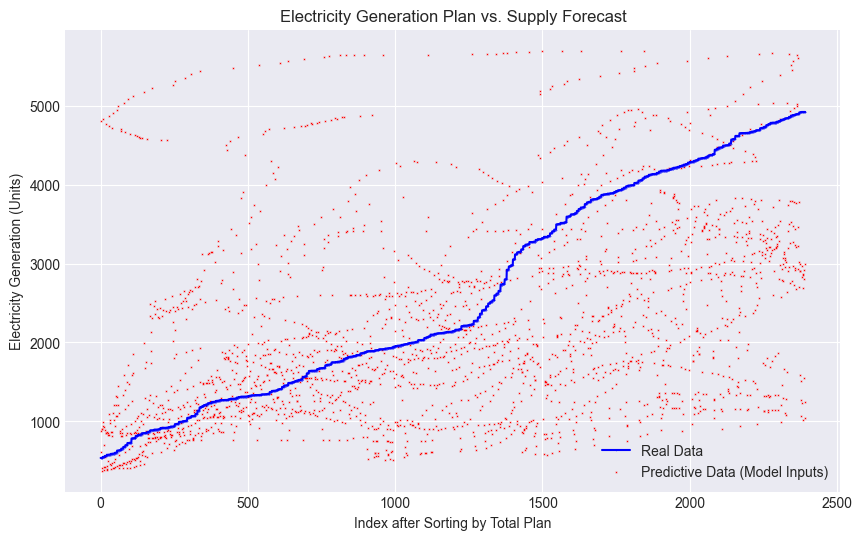

In [3]:
# 按 'total_plan' 进行排序
data_sorted = data.sort_values(by='实际值').reset_index(drop=True)
print(data_sorted)

# 设置matplotlib配置参数以支持中文显示
plt.rcParams['font.family'] = ['Arial Unicode MS']  # MacOS系统可用
# plt.rcParams['font.family'] = ['SimHei']  # Windows系统可用
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
# 设置绘图风格
plt.style.use('seaborn-darkgrid')

# 创建一个新的图形
plt.figure(figsize=(10, 6))

# 绘制 'total_plan' 作为发电量
plt.plot(data_sorted.index, data_sorted['实际值'], label='Real Data', color='blue', marker='o', linestyle='-', markersize=0.1)

# 使用点图绘制 '供电预测' 作为发电量
plt.scatter(data_sorted.index, data_sorted['预测值'], label='Predictive Data (Model Inputs)', color='red', marker='x', s=0.1)  # s 控制点的大小

# 添加图例
plt.legend()

# 添加标题和坐标轴标签
plt.title("Electricity Generation Plan vs. Supply Forecast")
plt.xlabel("Index after Sorting by Total Plan")
plt.ylabel("Electricity Generation (Units)")

# 显示图形
plt.show()


/var/folders/0l/n8_y01zn6xs5nr2z3l4vfg240000gn/T/ipykernel_4814/1019538603.py:40: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


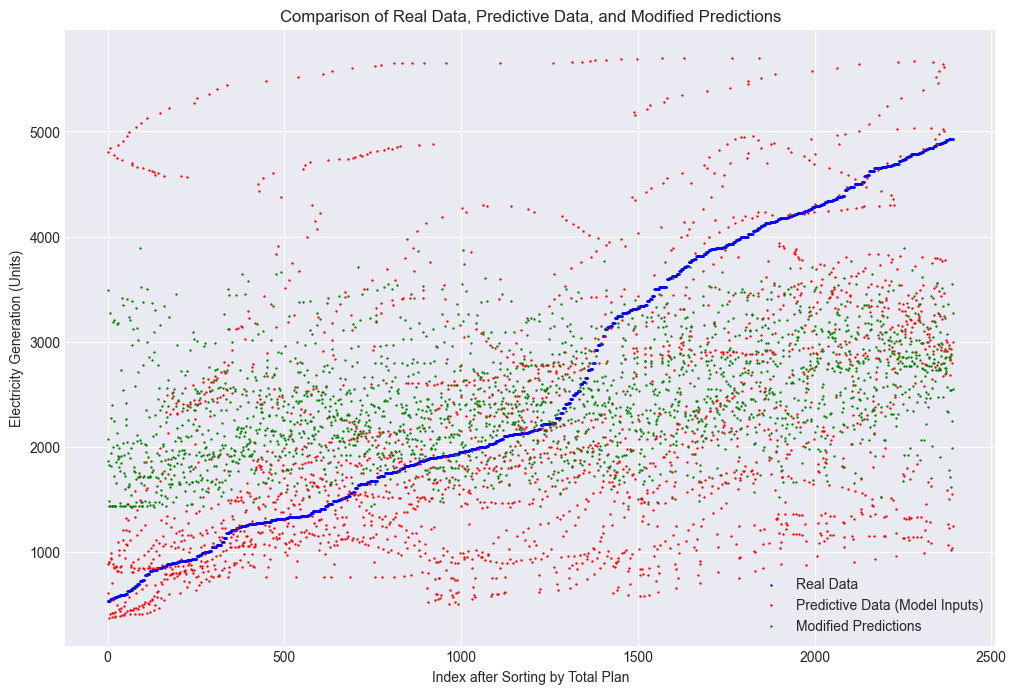

In [4]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 假设 data, dataset.scaler_features, dataset.scaler_labels, model 已经准备好

# 初始化一个列表来存储预测值
predicted_values = []

for index, row in data_sorted.iterrows():
    value1 = row['预测值']
    value2 = row['间隔天数']
    # 将当前值标准化
    normalized_value = dataset.scaler_features.transform([[value1,value2]])
    input_tensor = torch.from_numpy(normalized_value).float()
    input_tensor = input_tensor.view(1, -1)  # 确保其形状与模型输入的形状相匹配

    # 不需要计算梯度
    with torch.no_grad():
        X_new = input_tensor.cpu().numpy()
        output_tensor = gbr.predict(X_new)
        
   
    output_value = output_tensor.reshape(-1, 1)
    predicted_value = dataset.scaler_labels.inverse_transform(output_value)
    
    # 将预测值添加到列表中
    predicted_values.append(predicted_value[0][0])
    
# 确保predicted_values_sorted是一个Pandas Series，如果不是，可以通过下面的代码转换
predicted_values = pd.Series(predicted_values)

# 将预测值添加到排序后的DataFrame中
data_sorted['Modified_Predictions'] = predicted_values.values

# 现在，data_sorted已经包含了"Modified Predictions"字段，接下来可以绘图来比较实际数据、预测数据和修正后的预测数据

# 设置绘图风格
plt.style.use('seaborn-darkgrid')

# 创建一个新的图形
plt.figure(figsize=(12, 8))

# 绘制 'total_plan' 作为实际发电量
plt.scatter(data_sorted.index, data_sorted['实际值'], label='Real Data', color='blue', s=0.5)

# 绘制 '供电预测' 作为预测发电量
plt.scatter(data_sorted.index, data_sorted['预测值'], label='Predictive Data (Model Inputs)', color='red', s=0.5)

# 绘制修正后的预测值
plt.scatter(data_sorted.index, data_sorted['Modified_Predictions'], label='Modified Predictions', color='green', s=0.5)

# 添加图例
plt.legend()

# 添加标题和坐标轴标签
plt.title("Comparison of Real Data, Predictive Data, and Modified Predictions")
plt.xlabel("Index after Sorting by Total Plan")
plt.ylabel("Electricity Generation (Units)")

# 显示图形
plt.show()


/var/folders/0l/n8_y01zn6xs5nr2z3l4vfg240000gn/T/ipykernel_4814/4265089618.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


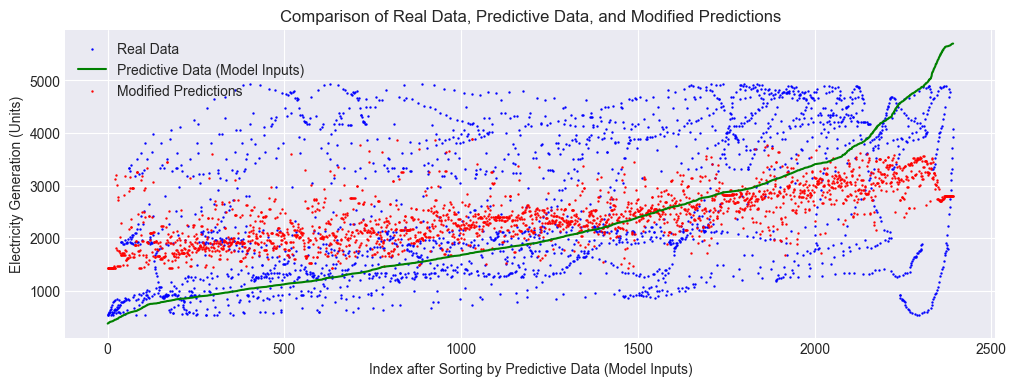

In [5]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 假设 data, dataset.scaler_features, dataset.scaler_labels, model 已经准备好

# 初始化一个列表来存储预测值
predicted_values = []
data_sorted = data_sorted.sort_values(by='预测值').reset_index(drop=True)
# 遍历 '供电预测' 中的每个值
    
# 确保predicted_values_sorted是一个Pandas Series，如果不是，可以通过下面的代码转换
predicted_values = pd.Series(predicted_values)

# 设置绘图风格
plt.style.use('seaborn-darkgrid')

# 创建一个新的图形
plt.figure(figsize=(12, 4))

# 绘制 'total_plan' 作为实际发电量
plt.scatter(data_sorted.index, data_sorted['实际值'], label='Real Data', color='blue', s=0.5)

# 绘制 '供电预测' 作为预测发电量
plt.plot(data_sorted.index, data_sorted['预测值'], label='Predictive Data (Model Inputs)', color='green',  linestyle='-')

# 绘制修正后的预测值
plt.scatter(data_sorted.index, data_sorted['Modified_Predictions'], label='Modified Predictions', color='red', s=0.5)

# 添加图例
plt.legend()

# 添加标题和坐标轴标签
plt.title("Comparison of Real Data, Predictive Data, and Modified Predictions")
plt.xlabel("Index after Sorting by Predictive Data (Model Inputs)")
plt.ylabel("Electricity Generation (Units)")

# 显示图形
plt.show()


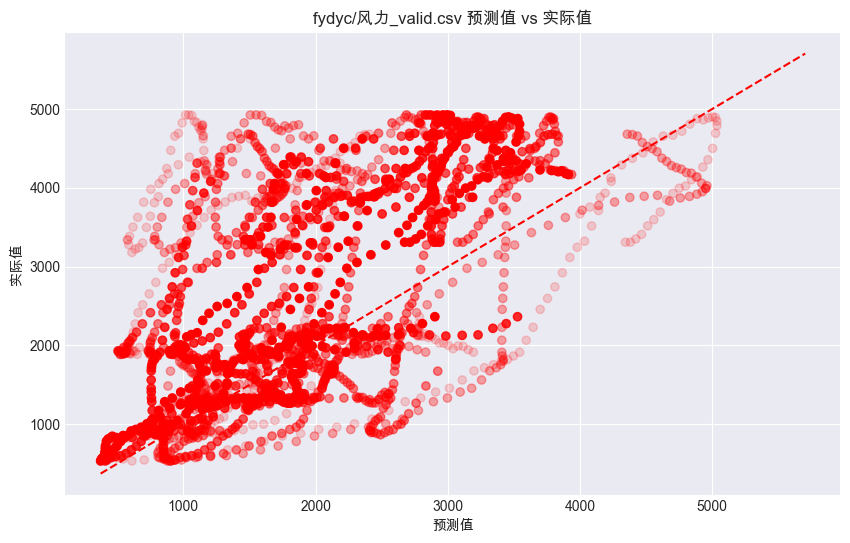

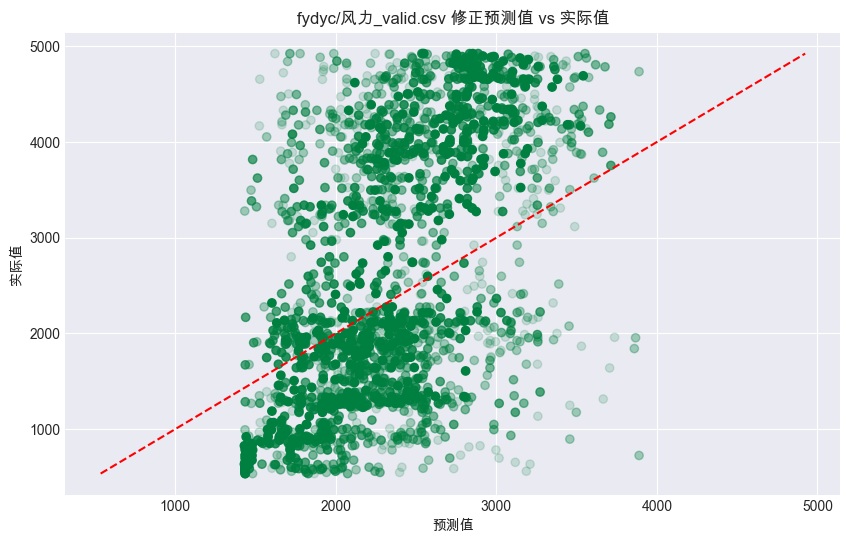

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 设置matplotlib配置参数以支持中文显示
plt.rcParams['font.family'] = ['Arial Unicode MS']  # MacOS系统可用
# plt.rcParams['font.family'] = ['SimHei']  # Windows系统可用
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 定义一个函数来读取数据、处理数据，并绘制预测值与实际值的散点图
def plot_prediction_vs_actual(file_name):
    # 读取CSV文件
    df = pd.read_csv(file_name, dtype=str)

    # 将预测值、实际值和间隔天数转换为数值类型
    df['预测值'] = data_sorted['预测值']
    df['实际值'] = data_sorted['实际值']
    df['间隔天数'] =  data_sorted['间隔天数']

    # 标准化间隔天数到0-1范围，用作点的透明度
    alpha_values = 1 - (df['间隔天数'] - df['间隔天数'].min()) / (df['间隔天数'].max() - df['间隔天数'].min())

    # 绘制预测值与实际值的散点图，透明度随间隔天数增加
    plt.figure(figsize=(10, 6))
    plt.scatter(df['预测值'], df['实际值'], color='red', alpha=alpha_values)

    # 添加图例、标题和轴标签
    plt.title(f'{file_name} 预测值 vs 实际值')
    plt.xlabel('预测值')
    plt.ylabel('实际值')

    # 绘制对角线，表示完美预测的位置
    max_value = max(df['预测值'].max(), df['实际值'].max())
    min_value = min(df['预测值'].min(), df['实际值'].min())
    plt.plot([min_value, max_value], [min_value, max_value], 'r--')

    # 显示图形
    plt.show()
    
def plot_modified_prediction_vs_actual(file_name):
    # 读取CSV文件
    df = pd.read_csv(file_name, dtype=str)

    # 将预测值、实际值和间隔天数转换为数值类型
    df['实际值'] = data_sorted['实际值']
    df['间隔天数'] =  data_sorted['间隔天数']
    df['预测值'] = data_sorted['Modified_Predictions']

    # 标准化间隔天数到0-1范围，用作点的透明度
    alpha_values = 1 - (df['间隔天数'] - df['间隔天数'].min()) / (df['间隔天数'].max() - df['间隔天数'].min())

    # 绘制预测值与实际值的散点图，透明度随间隔天数增加
    plt.figure(figsize=(10, 6))
    plt.scatter(df['预测值'], df['实际值'], color='#008040', alpha=alpha_values)

    # 添加图例、标题和轴标签
    plt.title(f'{file_name} 修正预测值 vs 实际值')
    plt.xlabel('预测值')
    plt.ylabel('实际值')

    # 绘制对角线，表示完美预测的位置
    max_value = max(df['预测值'].max(), df['实际值'].max())
    min_value = min(df['预测值'].min(), df['实际值'].min())
    plt.plot([min_value, max_value], [min_value, max_value], 'r--')

    # 显示图形
    plt.show()


plot_prediction_vs_actual(csv_file)
plot_modified_prediction_vs_actual(csv_file)


In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# 创建归一化器
scaler = MinMaxScaler()

# 对'预测值', '实际值', 'Modified_Predictions'进行归一化处理
data_normalized = scaler.fit_transform(data_sorted[['预测值', '实际值', 'Modified_Predictions']])

# 将归一化后的数据转换回DataFrame
data_normalized = pd.DataFrame(data_normalized, columns=['预测值_normalized', '实际值_normalized', 'Modified_Predictions_normalized'])

# 计算归一化后的'预测值'与'实际值'的MSE、RMSE和MAE
mse_pred = mean_squared_error(data_normalized['实际值_normalized'], data_normalized['预测值_normalized'])
rmse_pred = np.sqrt(mse_pred)
mae_pred = mean_absolute_error(data_normalized['实际值_normalized'], data_normalized['预测值_normalized'])

# 计算归一化后的'Modified_Predictions'与'实际值'的MSE、RMSE和MAE
mse_mod = mean_squared_error(data_normalized['实际值_normalized'], data_normalized['Modified_Predictions_normalized'])
rmse_mod = np.sqrt(mse_mod)
mae_mod = mean_absolute_error(data_normalized['实际值_normalized'], data_normalized['Modified_Predictions_normalized'])

# 打印结果
print(f"修正前: {mse_pred}, RMSE: {rmse_pred}, MAE: {mae_pred}")
print(f"修正后: {mse_mod}, RMSE: {rmse_mod}, MAE: {mae_mod}")


修正前: 0.11336202941690372, RMSE: 0.33669278194951513, MAE: 0.25397675040441214
修正后: 0.09378999253547249, RMSE: 0.30625151842149695, MAE: 0.24222200221854268
